## 使用 keras 做多分类任务

### 导入数据

Reuters dataset 包含一些短新闻以及对应的标签。这些短讯共有 46 个不同的话题，有的话题下包含的短讯多，有的包含的少，也就是说不同类别下样本数量分布不均匀。

In [2]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


2113536/2110848 [==============================] - 30s 14us/step


In [4]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((8982,), (8982,), (2246,), (2246,))

In [7]:
print(train_data[0])
print(train_labels[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


每条短讯中包含的是一组数字，这组数字是单词在单词表中的索引。可以获取到单词表，解码出短讯的原文。通常在竞赛中，文本数据都是这样给出来的，因为不用解码出原文也可能完成分类等操作，不给出原文也可以包含竞赛组织方的数据安全，因为原文中可能存在敏感信息。

In [10]:
word_index = reuters.get_word_index()
reverse_word_index = {value: key for (key, value) in word_index.items()}

# Note that the indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
newswire_text = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])
newswire_text

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

### 预处理数据

In [11]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
    
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [12]:
x_train.shape, x_test.shape

((8982, 10000), (2246, 10000))

对标签做 one-hot 编码

In [13]:
def to_one_hot(labels, dim=46):
    results = np.zeros((len(labels), dim))
    for index, label in enumerate(labels):
        results[index, label] = 1
    return results

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [14]:
y_train.shape

(8982, 46)

这一步也可以使用 keras 内置函数轻松搞定：

```python
from keras.utils.np_utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)
```

### 构建网络

In [16]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 训练网络

在初次训练的时候，需要加入验证集，以选择更好的模型参数。比如神经网络的隐层数，神经元数据，激活函数等。

In [18]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [19]:
model.fit(partial_x_train, partial_y_train,
          epochs=20, batch_size=512,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 194us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 120us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 117us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 119us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 123us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 120us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 119us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020


### 对训练结果可视化

对训练过程中的 loss 和 acc 进行可视化

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15,5))

    plt.subplot(121)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'g-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'g-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()

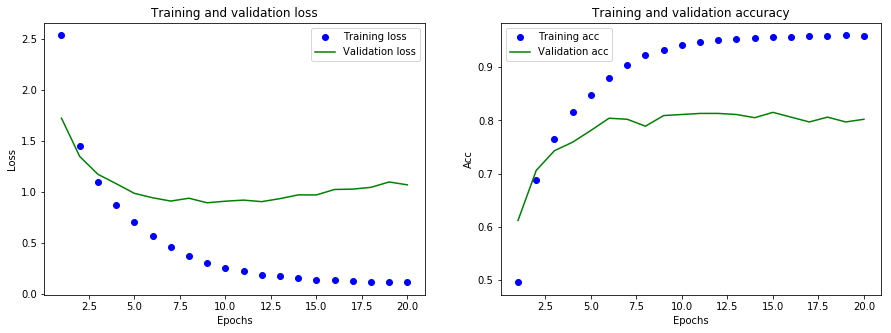

In [21]:
plot_history(model.history)

可以看出大约在第 9 个 epoch 后开始出现 overfitting，因此可以重新训练网络，这一次使用全部训练数据训练 9 个 epoch。

### 重新训练模式

In [46]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=9, batch_size=512)

Epoch 1/9
8982/8982 [==============================] - 2s 204us/step - loss: 2.6106 - acc: 0.5578
Epoch 2/9
8982/8982 [==============================] - 1s 127us/step - loss: 1.3228 - acc: 0.7356
Epoch 3/9
8982/8982 [==============================] - 1s 124us/step - loss: 0.9573 - acc: 0.8009
Epoch 4/9
8982/8982 [==============================] - 1s 119us/step - loss: 0.7494 - acc: 0.8427
Epoch 5/9
8982/8982 [==============================] - 1s 129us/step - loss: 0.5909 - acc: 0.8778
Epoch 6/9
8982/8982 [==============================] - 1s 116us/step - loss: 0.4740 - acc: 0.9017
Epoch 7/9
8982/8982 [==============================] - 1s 126us/step - loss: 0.3840 - acc: 0.9204
Epoch 8/9
8982/8982 [==============================] - 1s 122us/step - loss: 0.3137 - acc: 0.9332
Epoch 9/9
8982/8982 [==============================] - 1s 123us/step - loss: 0.2657 - acc: 0.9397


### 在测试集上评估模型

In [47]:
model.evaluate(x_test, y_test)

2246/2246 [==============================] - 1s 305us/step


[0.9764048770826412, 0.7831700801955518]

在测试集上只得到了 78% 的精度，感觉还是有些 overfitting。尝试采用 4, 6, 9 等不同的 epoch，均发现测试集上的准确率低训练集近 10 个百分点。这是怎么回事？

### 多分类的另外一种处理方法

这里每个样本只会被分到一个类别下，训练的时候标签是一个 one-hot 的向量。keras 提供了另外一种方式，使用损失函数 `sparse_categorical_crossentropy` ，此时标签就可以是单个数字，该数字为样本的实际类别。

```python
y_train = np.array(train_labels)
y_test = np.array(test_labels)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
```

### 更多尝试

#### 增加隐层神经元数量

In [49]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train,
          epochs=20, batch_size=512,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 261us/step - loss: 2.2067 - acc: 0.5695 - val_loss: 1.3590 - val_acc: 0.6900
Epoch 2/20
7982/7982 [==============================] - 1s 146us/step - loss: 1.0885 - acc: 0.7626 - val_loss: 1.1122 - val_acc: 0.7360
Epoch 3/20
7982/7982 [==============================] - 1s 154us/step - loss: 0.7680 - acc: 0.8348 - val_loss: 0.9630 - val_acc: 0.7990
Epoch 4/20
7982/7982 [==============================] - 1s 149us/step - loss: 0.5568 - acc: 0.8810 - val_loss: 0.9013 - val_acc: 0.8060
Epoch 5/20
7982/7982 [==============================] - 1s 155us/step - loss: 0.3990 - acc: 0.9159 - val_loss: 0.8764 - val_acc: 0.8170
Epoch 6/20
7982/7982 [==============================] - 1s 149us/step - loss: 0.3153 - acc: 0.9344 - val_loss: 0.8823 - val_acc: 0.8170
Epoch 7/20
7982/7982 [==============================] - 1s 157us/step - loss: 0.2484 - acc: 0.9409 - val_loss: 0.9214 - val_acc: 0.8100


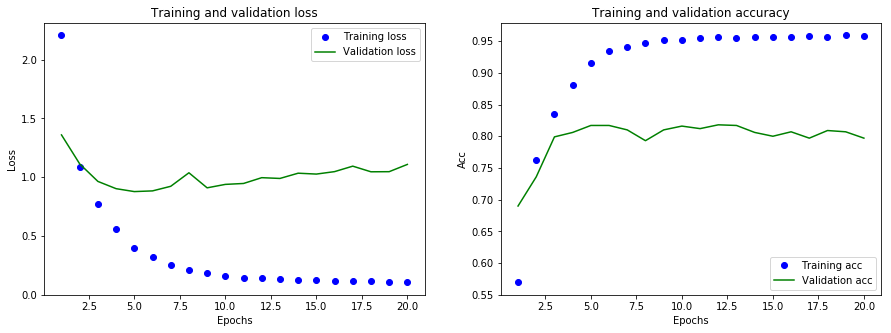

In [50]:
plot_history(model.history)

In [51]:
model.evaluate(x_test, y_test)

2246/2246 [==============================] - 1s 294us/step


[1.2103950435947544, 0.786731967996086]

#### 增加隐层数量

Train on 7982 samples, validate on 1000 samples
Epoch 1/6
7982/7982 [==============================] - 2s 292us/step - loss: 2.3349 - acc: 0.5301 - val_loss: 1.4420 - val_acc: 0.6470
Epoch 2/6
7982/7982 [==============================] - 1s 158us/step - loss: 1.1731 - acc: 0.7311 - val_loss: 1.2857 - val_acc: 0.7020
Epoch 3/6
7982/7982 [==============================] - 1s 150us/step - loss: 0.8477 - acc: 0.8078 - val_loss: 0.9970 - val_acc: 0.7890
Epoch 4/6
7982/7982 [==============================] - 1s 160us/step - loss: 0.6056 - acc: 0.8603 - val_loss: 0.9458 - val_acc: 0.8020
Epoch 5/6
7982/7982 [==============================] - 1s 150us/step - loss: 0.4522 - acc: 0.9017 - val_loss: 0.9357 - val_acc: 0.8070
Epoch 6/6
7982/7982 [==============================] - 1s 156us/step - loss: 0.3307 - acc: 0.9260 - val_loss: 0.9870 - val_acc: 0.7960


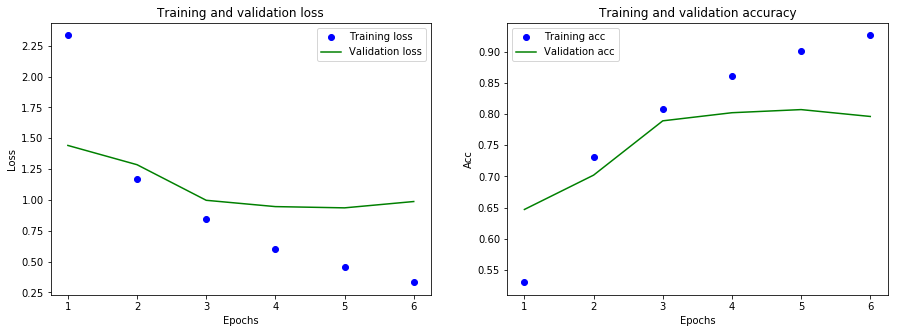

In [59]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train,
          epochs=6, batch_size=512,
          validation_data=(x_val, y_val))

plot_history(model.history)

In [60]:
model.evaluate(x_test, y_test)

2246/2246 [==============================] - 1s 314us/step


[1.0689308639094963, 0.7756010685928783]

增加隐层和隐层的神经元数量，看样子只会加剧过拟合